# The backward pass (in theory)

So, you want to compute the derivatives of computational graphs. To make things concrete, we'll use our running example, the logistic regression.

In mathematical terms, logistic regression is defined by the function

$$
f(a, b, x) = \sigma(a x + b),
$$

where $ x $ is the input, and $ a, b $ are the model parameters. Our ultimate goal is to compute the rate of change of $ f $ with respect to the parameters $ a $ and $ b $; that is, the derivatives $ \frac{\partial f}{\partial a} $ and $ \frac{\partial f}{\partial b} $.

How to do that? Experienced calculus users immediately reply

$$
\begin{align*}
\frac{\partial f}{\partial a} &= x \sigma^\prime(ax + b), \\
\frac{\partial f}{\partial b} &= \sigma^\prime(ax + b),
\end{align*}
$$

but how was that obtained? By the *chain rule*, one of the most important results in mathematics. However, to fully understand what the chain rule is, we have to dive deep into the wonderful (and mildly convoluted) world of derivatives.

## Derivatives and partial derivatives

At some point in your life, you have probably encountered the concept of *differentiation* and *derivatives*. We don't have all the time in the world here, but let's recap; it's best if we tackle the tough topic of backpropagation fully prepared. If you are thoroughly familiar with the concept, feel free to skip to the {ref}`chain rule <section:backward-pass/chain-rule>`, but I recommend you to refresh your knowledge.

In pure English, derivatives describe the rate of change. Let's see the formal definition.

````{prf:definition} The derivative.
Let $ f: \mathbb{R} \to \mathbb{R} $ be a function of one variable. We say that $ f $ is *differentiable at* $ \mathbf{x}_0 \in \mathbb{R} $ if the limit

$$
\frac{df}{dx}(x_0) := \lim_{x \to x_0} \frac{f(x) - f(x_0)}{x - x_0}
$$

exists. If so, $ \frac{df}{dx}(x_0) $ is called the *derivative* of $ f $ at $ x_0 $. If $ f $ is differentiable everywhere, then it is said to be *differentiable*.
````

Two remarks about the notation. First, when it's clear, the argument is omitted from the so-called Leibniz notation $ \frac{df}{dx} = \frac{df}{dx}(x_0) $. 
Second, for univariate functions, the derivate is also denoted by $ f^\prime(x_0) $; we'll use this quite frequently.

Geometrically speaking, the $ f^\prime(x_0) $ describes the slope of the tangent line drawn at the graph of $ f $ at the point $ (x_0, f(x_0)) $.

It's the best to visualize this, so we'll take a look at the function $ f(x) = x^2 $, whose derivative is $ f^\prime(x) = 2x $.

In [1]:
def f(x):
    return x**2

def df(x):
    return 2*x

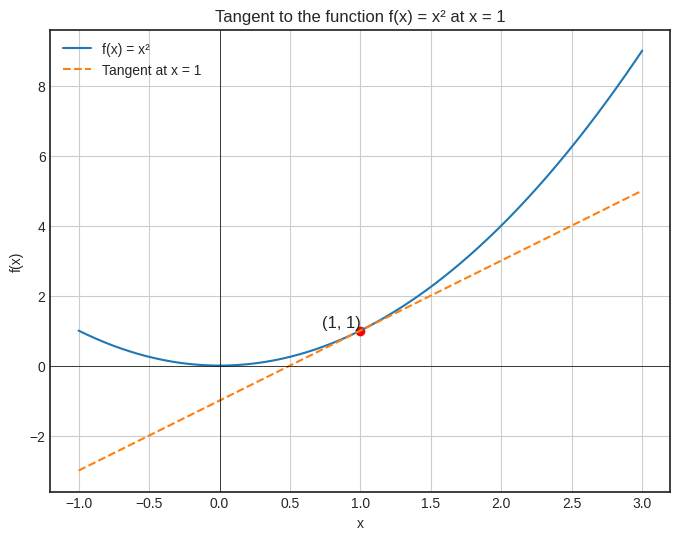

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def tangent_line(x, x_0):
    return df(x_0) * (x - x_0) + f(x_0)

x_0 = 1
y_0 = f(x_0)
slope = df(x_0)

x_vals = np.linspace(-1, 3, 400)
y_vals = f(x_vals)
tangent_vals = tangent_line(x_vals, x_0)

with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, y_vals, label='f(x) = x²')
    plt.plot(x_vals, tangent_vals, '--', label=f'Tangent at x = {x_0}')
    plt.scatter([x_0], [y_0], color='red')
    plt.text(x_0, y_0, f'({x_0}, {y_0})', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.title('Tangent to the function f(x) = x² at x = 1')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

However, in multiple variables, the definition breaks down. For instance, consider $ f(x, y) = x^2 + y^2 $, the two-variable version of the previous function. There, instead of a tangent line, we have a tangent *plane*.

In [3]:
def f(x, y):
    return x**2 + y**2

def df_dx(x, y):
    return 2*x

def df_dy(x, y):
    return 2*y

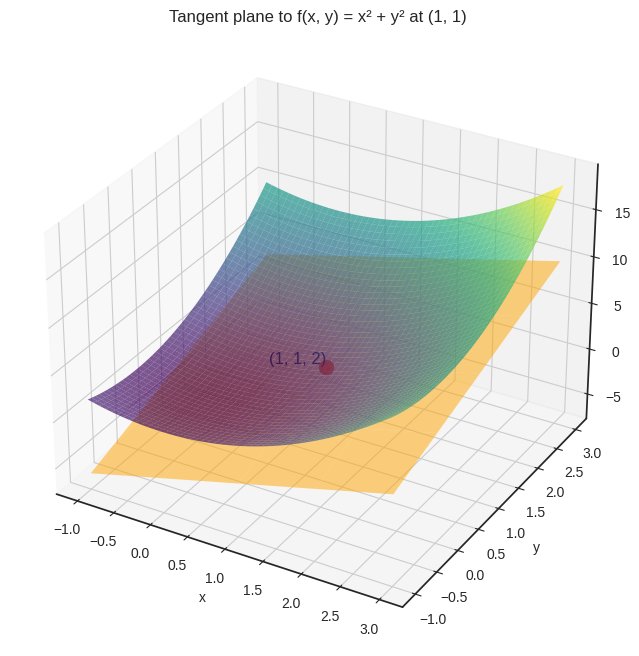

In [4]:
from mpl_toolkits.mplot3d import Axes3D


def tangent_plane(x, y, x0, y0):
    return f(x0, y0) + df_dx(x0, y0) * (x - x0) + df_dy(x0, y0) * (y - y0)

x0, y0 = 1, 1
z0 = f(x0, y0)

x_vals = np.linspace(-1, 3, 400)
y_vals = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = f(X, Y)
Z_tangent = tangent_plane(X, Y, x0, y0)

with plt.style.context("seaborn-v0_8-white"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, label='f(x, y) = x^2 + y^2')
    ax.plot_surface(X, Y, Z_tangent, color='orange', alpha=0.5, rstride=100, cstride=100)

    ax.scatter([x0], [y0], [z0], color='red', s=100)
    ax.text(x0, y0, z0, f'({x0}, {y0}, {z0})', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    ax.set_title('Tangent plane to f(x, y) = x² + y² at (1, 1)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')

    plt.show()


In this case, we can fix all but one variable, and take the derivative of the thus obtained single-variable function. This is called the *partial derivative*. Here's the formal definition.

````{prf:definition} The partial derivatives.

Let $ f: \mathbb{R}^n \to \mathbb{R} $ be a function of $ n $ variables. We say that $ f $ is *partially differentiable* at $ \mathrm{x}_0 \in \mathbb{R}^n $ in the $ i $-th variable if the limit

$$
\frac{\partial f}{\partial x_i}(\mathbf{x}_0) := \lim_{h \to 0} \frac{f(\mathbf{x}_0 + h \mathbf{e}_i) - f(\mathbf{x}_0)}{h}
$$

exists, where $ \mathbf{e}_i $ is the vector whose $ i $-th coordinate is one, and the rest is zero. If so, $ \frac{\partial f}{\partial x_i}(\mathbf{x}_0) $ is called the $ i $-th *partial derivative* of $ f $ at $ \mathbf{x}_0 $.
````

Again, when it's clear, we often write $ \frac{\partial f}{\partial x_i} $ instead of $ \frac{\partial f}{\partial x_i}(\mathbf{x}_0) $.

Let's look at an example! In the case of $ f(x, y) = x^2 + y^3 $, the partial derivatives are

$$
\frac{\partial f}{\partial x} = 2x, \quad \frac{\partial f}{\partial y} = 3y^2.
$$

````{prf:remark} Derivatives vs partial derivatives in function compositions.

When vigorously composing functions and variables (as we do in machine learning), a clear distinction must be made between regular and partial derivatives. For example, consider the functions $ f(x, y) = x + y^2 $ and $ g(x, y) = \sin(x)\cos(y) $. If $ x $ and $ y $ represent a particular feature like height, cost, etc., and $ g(x, y) $ is an engineered feature, we end up with expressions like

$$
\begin{align*}
h(x, y) &= f(g(x, y), y) \\
&= \sin(x)\cos(y) + y^2.
\end{align*}
$$

In this context, $ \frac{df}{dy} $ and $ \frac{\partial f}{\partial y} $ mean two different things:

* while $ \frac{\partial f}{\partial y} $ is the partial derivative of $ f $ with respect to $ y $,
* the expression $ \frac{df}{dy} $ refers to the univariate function defined by $ y \to f(g(x, y), y) $, or in other words, $ \frac{df}{dy} = \frac{\partial h}{\partial y} $.

Keep this in mind, as we won't always explicitly name composite expressions such as $ f(g(x, y), y) $.
````

Speaking of composed functions: it's time to dive into the chain rule, our main tool for differentiating computational graphs.

(section:backward-pass/chain-rule)=
## The chain rule
 
 Let's state the chain rule right away. Single variable first, multiple variables second.

````{prf:theorem} Chain rule, single variable.

Let $ f, g: \mathbb{R} \to \mathbb{R} $ be two differentiable functions, and let $ h(x) = f(g(x)) $. Then

$$
\Big( f\big(g(x)\big) \Big)^\prime = f^\prime\big(g(x)\big) g^\prime(x).
$$

or in other words,

$$
\frac{dh}{dx} = \frac{df}{dg} \frac{dg}{dx},
$$
````

In English, this means that the derivative of the composite function equals the product of the components' derivatives, evaluated at the appropriate locations.

````{prf:remark} Abuse of notation.
If you are an attentive reader, perhaps you've noticed that there's a discrepancy between the notations $ f^\prime(g(x)) $, $ \frac{df}{dx} $, $ \frac{df}{dg} $, and so on.

For instance, $ \frac{df}{dx} $ and $ \frac{df}{dg} $ doesn't make sense, as the function $ f $ is univariate, defined in terms of an arbitrary variable $ x $. So, what's $ \frac{df}{dg} $? Let's clear this up once and for all.

According to the chain rule, the derivative of the composed function $ f(g(x)) $ is

$$
\Big( f\big(g(x)\big) \Big)^\prime = f^\prime\big(g(x)\big) g^\prime(x),
$$

in other words, the derivative function $ f^\prime $ is evaluated at $ g(x) $. To avoid writing monstrosities like $ \frac{df}{dx}(g(x)) $, we rather think of $ f $ as defined in terms of the variable $ g = g(x) $, and simply write $ \frac{df}{dg} $, which is shorthand for

$$
\frac{df}{dg} = \frac{df}{dx}(g(x)) = f^\prime(g(x)).
$$
````

For multiple variables, the chain rule goes like the following.

````{prf:theorem} Chain rule, multiple variables.

Let $ f: \mathbb{R}^m \to \mathbb{R} $ be a function of $ m $ variables, let $ g_1, \dots, g_m: \mathbb{R}^n \to \mathbb{R} $, and define $ h: \mathbf{R}^n \to \mathbb{R} $ by

$$
h(\mathbf{x}) = f\big( g_1(\mathbf{x}), \dots, g_m(\mathbf{x}) \big), \quad \mathbf{x} = (x_1, \dots, x_n).
$$

Then

$$
\frac{\partial h}{\partial x_i} = \sum_{j=1}^{m} \frac{\partial f}{\partial g_j} \frac{\partial g_j}{\partial x_i}
$$

````

How does this apply to the logistic regression? As we've seen that before, $ f(a, b, x) = \sigma(a x + b) $ is a composite function, built from the blocks

$$
\begin{align*}
c(a, x) &= a x, \\
y(c, b) &= c + b, \\
\sigma(y) &= \frac{1}{1 + e^{-y}}
\end{align*}
$$

that yield

$$
f(a, b, x) = \sigma\Big(y\big(c(a, x), b\big) \Big).
$$

Thus,

$$
\begin{align*}
\frac{\partial f}{\partial a} &= \frac{\partial \sigma}{\partial y} \frac{\partial y}{\partial a} \\
&= \frac{\partial \sigma}{\partial y} \bigg( \frac{\partial y}{\partial c} \frac{\partial c}{\partial a} + \frac{\partial y}{\partial b} \frac{\partial b}{\partial a} \bigg) \\
&= \sigma^\prime(ax + b) \bigg( 1 \cdot x + 1 \cdot 0 \bigg) \\
&= x \sigma^\prime(ax + b),
\end{align*}
$$

as we've seen it earlier.

Because of the layered structure of neural networks, the chain rule will be our bread and butter in calculating the derivatives. Now that we understand how it works, let's see what the chain rule means in the context of computational graphs!

## The chain rule and computational graphs

Let's go back to square one and consider the composite function $ f(g(x)) $. In computational graph terms, we prefer to work with *variables*, not functions. That is, instead of $ f(g(x)) $, we have the variables `x`, `g`, `f`, the elements of our computations.

Here's how this simple graph looks.

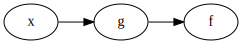

In [5]:
from graphviz import Digraph


digraph = Digraph()
digraph.attr(rankdir='LR')

digraph.node("x", "x")
digraph.node("g", "g")
digraph.node("f", "f")
digraph.edges(["xg", "gf"])

digraph

````{prf:remark} Abuse of notation, part 2.

Note that in the above computational graph, `g` is not the mathematical function $ g $, nor does `f` mean $ f $. The variables are the results of the computations defined by the functions. Mathematically speaking, we have
* the input $ x $,  
* the variable $ g = g(x) $,  
* and the variable $ f = f(g) $.

In principle, we are not allowed to designate the same symbol to different variables, but adding another set of symbols would be cumbersome. Thus, we take a hit in precision to gain a bit of simplicity.

Accordingly,

* $ \frac{df}{dx} $ the derivative of $ f(g(x)) $ with respect to $ x $,
* while $ \frac{df}{dg} $ is the derivative of $ f $ with respect to its only variable $ g $.

Keep this in mind when translating expressions to computational graphs.
````

In the language of computational graphs, the chain rule expresses the derivative of the terminal node `f` with respect to the initial node `x`. Essentially, we compute the following graph.

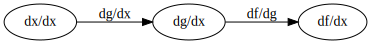

In [6]:
digraph = Digraph()
digraph.attr(rankdir='LR')

digraph.node("x", "dx/dx")
digraph.node("g", "dg/dx")
digraph.node("f", "df/dx")
digraph.edge("x", "g", label="dg/dx")
digraph.edge("g", "f", label="df/dg")

digraph

This is quite overloaded with information, so let me explain. In the derivative graph,
* a node corresponds to the derivative of the original node with respect to the initial node `x`,  
* and an edge corresponds to the derivative of its end node with respect to its start node.

Using the chain rule, we obtain the values in the nodes by multiplying together all the edges leading up to it: $ \frac{df}{dx} = \frac{df}{dg} \frac{dg}{dx} $.

Because we progress from the initial node `x` to the terminal node `f`, this is called *forward-mode differentiation*. Accordingly, the
* derivatives represented by the nodes are called the *forward derivatives*,
* and the derivatives on the edge are called *local derivatives*.

Let's see an example to solidify your understanding: consider the expression $ (3x)^2 $. In this setting, $ g(x) = 3x $ and $ f(g) = g^2 $. Thus, we have

$$
\begin{align*}
\frac{\partial g}{\partial x} &= 3, \\
\frac{\partial f}{\partial g} &= 2 g.
\end{align*}
$$

For, say, $ x = 4 $, we can immediately compute the forward pass and the local derivatives: 

$$
\begin{align*}
g(x) &= 3 \cdot 4 = 12, \\
f(g) &= 12^2 = 144, \\
\frac{dg}{dx} &= 3, \\
\frac{df}{dg} &= 2 \cdot 12 = 24.
\end{align*}
$$

Thus, in the first step, we populate the edges and the first node of the derivative graph.

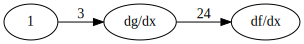

In [7]:
digraph = Digraph()
digraph.attr(rankdir='LR')

digraph.node("x", "1")
digraph.node("g", "dg/dx")
digraph.node("f", "df/dx")
digraph.edge("x", "g", label="3")
digraph.edge("g", "f", label="24")

digraph

The second node is computed by taking the product of the first node and the first edge. (As the first node's value is $ 1 $, this'll match the edge.)

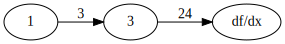

In [8]:
digraph = Digraph()
digraph.attr(rankdir='LR')

digraph.node("x", "1")
digraph.node("g", "3")
digraph.node("f", "df/dx")
digraph.edge("x", "g", label="3")
digraph.edge("g", "f", label="24")

digraph

In the last step, we compute $ \frac{df}{dx} $ by taking the product of $ \frac{df}{dg} = 24 $ and $ \frac{dg}{dx} = 3 $:

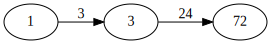

In [9]:
digraph = Digraph()
digraph.attr(rankdir='LR')

digraph.node("x", "1")
digraph.node("g", "3")
digraph.node("f", "72")
digraph.edge("x", "g", label="3")
digraph.edge("g", "f", label="24")

digraph

To get a firm grasp on how forward-mode differentiation works, let's put one more node and consider the graph given by $ h(f(g(x))) $:

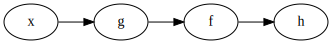

In [10]:
digraph = Digraph()
digraph.attr(rankdir='LR')

digraph.node("x", "x")
digraph.node("g", "g")
digraph.node("f", "f")
digraph.node("h", "h")
digraph.edges(["xg", "gf", "fh"])

digraph

To check your understanding, try to carry through the previous process by
* sketching the derivative graph,
* and computing the derivatives of the nodes with respect to the initial node `x`.

Welcome back! This is what you should have got:

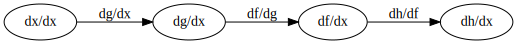

In [11]:
digraph = Digraph()
digraph.attr(rankdir='LR')

digraph.node("x", "dx/dx")
digraph.node("g", "dg/dx")
digraph.node("f", "df/dx")
digraph.node("h", "dh/dx")
digraph.edge("x", "g", label="dg/dx")
digraph.edge("g", "f", label="df/dg")
digraph.edge("f", "h", label="dh/df")

digraph

To confirm, the iterated application of the chain rule gives

$$
\begin{align*}
\frac{dh}{dx} &= \frac{dh}{df} \frac{df}{dx} \\
&= \frac{dh}{df} \frac{df}{dg} \frac{dg}{dx}.
\end{align*}
$$

Now you understand why the chain rule is called the *chain* rule! The next step is see what happens in a multivariable context.

### The multivariable case

Let's turn the difficulty dial up a notch and consider the expression

$$
f\big(g_1(x), g_2(x)\big),
$$

which is composed of

* a bivariate function $ f: \mathbb{R}^2 \to \mathbb{R} $,
* and two univariate functions $ g_1, g_2: \mathbb{R} \to \mathbb{R} $.

Sketching up its graph, we obtain the following:

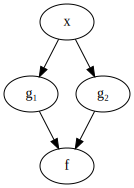

In [12]:
digraph = Digraph()

digraph.node("x")
digraph.node("g₁")
digraph.node("g₂")
digraph.node("f")
digraph.edges([("x", "g₁"), ("x", "g₂"),
               ("g₁", "f"), ("g₂", "f"),])


digraph

Again, our goal is to calculate $ \frac{df}{dx} $. To do that, we employ the (multivariate) chain rule

$$
\frac{df}{dx} = \frac{\partial f}{\partial g_1} \frac{\partial g_1}{\partial x} + \frac{\partial f}{\partial g_2} \frac{\partial g_2}{\partial x},
$$

or in computational graph terms:

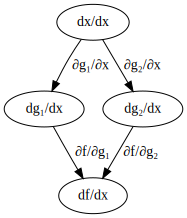

In [13]:
digraph = Digraph()

nodes = ["x", "g₁", "g₂", "f"]
edges = [("x", "g₁"), ("x", "g₂"), ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(v, f"d{v}/dx")

for u, v in edges:
    digraph.edge(u, v, f"∂{v}/∂{u}")

digraph

(Note that here, $ \frac{dg_1}{dx} = \frac{\partial g_1}{\partial x} $ and $ \frac{dg_2}{dx} = \frac{\partial g_2}{\partial x} $.) In this case, the derivative $ \frac{d f}{d x} $ is obtained via forward-mode differentiation; that is,

1. computing the local derivatives on the edges,
2. taking a path from the initial node `x` to the terminal node `f`,
3. multiplying together all intermediate derivatives along the edges,
4. and summing the products for all paths.

Take a look at the expression

$$
\frac{df}{dx} = \frac{\partial f}{\partial g_1} \frac{\partial g_1}{\partial x} + \frac{\partial f}{\partial g_2} \frac{\partial g_2}{\partial x},
$$

where the first term $ \frac{\partial f}{\partial g_1} \frac{\partial g_1}{\partial x} $ corresponds to the left path, while $ \frac{\partial f}{\partial g_2} \frac{\partial g_2}{\partial x} $ corresponds to the right one.

From top to bottom, we compute

1. $ \frac{dx}{dx} $,
2. $ \frac{dg_1}{dx} $ and $ \frac{dg_2}{dx} $,
3. and finally $ \frac{df}{dx} $,

in this exact order.

Like before, we'll walk through a concrete example: $ \sin(x) \cos(x) $. This expression is a composition of two univariate functions $ g_1(x) = \sin(x) $, $ g_2(x) = \cos(x) $, and a bivariate function $ f(g_1, g_2) = g_1 \cdot g_2 $. Regarding its derivatives, we have

$$
\begin{align*}
\frac{\partial g_1}{\partial x} &= \cos(x), \\
\frac{\partial g_2}{\partial x} &= -\sin(x),
\end{align*}
$$

and

$$
\begin{align*}
\frac{\partial f}{\partial g_1} &= g_2, \\
\frac{\partial f}{\partial g_2} &= g_1.
\end{align*}
$$

So, what would calculating the derivative look like for, say, $ x = 2 $? Let's begin populating the derivative graph with the edges and the first node.

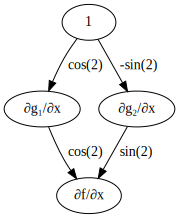

In [14]:
digraph = Digraph()

nodes = [("x", "1"), ("g₁", "∂g₁/∂x"), ("g₂", "∂g₂/∂x"), ("f", "∂f/∂x")]
edges = [("x", "g₁", "cos(2)"), ("x", "g₂", "-sin(2)"), ("g₁", "f", "cos(2)"), ("g₂", "f", "sin(2)")]

for v, v_label in nodes:

    digraph.node(v, v_label)

for u, v, label in edges:
    digraph.edge(u, v, label=label)

digraph

With this, we can move one step further and compute the derivatives of the first-level nodes.

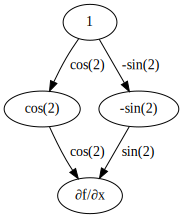

In [15]:
digraph = Digraph()

nodes = [("x", "1"), ("g₁", "cos(2)"), ("g₂", "-sin(2)"), ("f", "∂f/∂x")]
edges = [("x", "g₁", "cos(2)"), ("x", "g₂", "-sin(2)"), ("g₁", "f", "cos(2)"), ("g₂", "f", "sin(2)")]

for v, v_label in nodes:

    digraph.node(v, v_label)

for u, v, label in edges:
    digraph.edge(u, v, label=label)

digraph

The final step. According to the chain rule, the derivative is the sum of the values of all the incoming edges times their parents' derivative for each node. In simpler terms,

$$
\frac{\partial f}{\partial x} = \frac{\partial f}{\partial g_1} \frac{\partial g_1}{\partial x} + \frac{\partial f}{\partial g_2} \frac{\partial g_2}{\partial x},
$$

Let's state this in graph form.

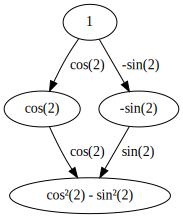

In [16]:
digraph = Digraph()

nodes = [("x", "1"), ("g₁", "cos(2)"), ("g₂", "-sin(2)"), ("f", "cos²(2) - sin²(2)")]
edges = [("x", "g₁", "cos(2)"), ("x", "g₂", "-sin(2)"), ("g₁", "f", "cos(2)"), ("g₂", "f", "sin(2)")]

for v, v_label in nodes:

    digraph.node(v, v_label)

for u, v, label in edges:
    digraph.edge(u, v, label=label)

digraph

If you want to practice, feel free to carry out the previous process on the expression $ \cos(x^2) \sin(x^2) $.

One more example to emphasize the difference between local derivatives $ \partial/\partial x $ and global derivatives $ d/dx $. Let's put one more layer into the above graph and consider the expression

$$
f\Big(g_1\big(h_1(x)\big), g_2\big(h_2(x)\big)\Big),
$$

yielding the following (derivative) graph.

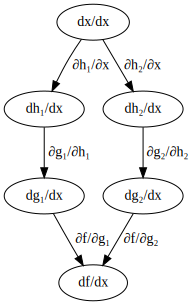

In [17]:
digraph = Digraph()

nodes = ["x", "h₁", "h₂", "g₁", "g₂", "f"]
edges = [("x", "h₁"), ("x", "h₂"), ("h₁", "g₁"), ("h₂", "g₂"), ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(v, f"d{v}/dx")

for u, v in edges:
    digraph.edge(u, v, f"∂{v}/∂{u}")

digraph

Here, the chain rule says that

$$
\begin{align*}
\frac{df}{dx} &= \frac{\partial f}{\partial g_1} \frac{dg_1}{dx} + \frac{\partial f}{\partial g_2} \frac{dg_2}{dx} \\
&= \frac{\partial f}{\partial g_1} \frac{\partial g_1}{\partial h_1} \frac{\partial h_1}{\partial x} + \frac{\partial f}{\partial g_2} \frac{\partial g_2}{\partial h_2} \frac{\partial h_2}{\partial x}.
\end{align*}
$$

Note that the terms $ \frac{\partial f}{\partial g_i} \frac{\partial g_i}{\partial h_i} \frac{\partial h_i}{\partial x} $ correspond to paths from `x` to `f`, while $ \frac{\partial f}{\partial g_i} \frac{dg_i}{dx} $ correspond to all incoming edges and parents of `f`.

Now, it's time to put a twist on everything that we've learned so far regarding the chain rule!

### The problems with forward-mode differentiation

Let's increase the complexity once more and consider the computational graph defined by the expression

$$
f\big( g_1(x_1, x_2), g_2(x_1, x_2) \big),
$$

which looks like the following.

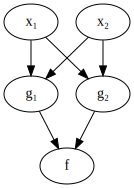

In [18]:
digraph = Digraph()

nodes = ["x₁", "x₂", "g₁", "g₂", "f"]
edges = [("x₁", "g₁"), ("x₁", "g₂"),
         ("x₂", "g₁"), ("x₂", "g₂"),
         ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

As there are two initial nodes $ x_1 $ and $ x_2 $, we would like to compute both $ \frac{df}{dx_1} $ and $ \frac{df}{dx_2} $. This presents us with a problem, as now we have to compute two graphs:

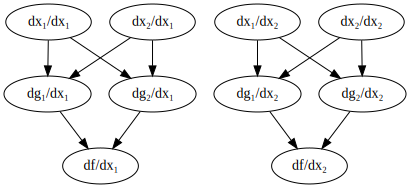

In [19]:
digraph = Digraph()

nodes = ["x₁", "x₂", "g₁", "g₂", "f"]
edges = [("x₁", "g₁"), ("x₁", "g₂"),
         ("x₂", "g₁"), ("x₂", "g₂"),
         ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(v, label=f"d{v}/dx₁")

for u, v in edges:
    digraph.edge(u, v)

offset = " "
for v in nodes:
    digraph.node(v + offset, label=f"d{v}/dx₂")

edges_offset = [(u + offset, v + offset) for u, v in edges]
for u, v in edges_offset:
    digraph.edge(u, v)

digraph

(I have omitted the edge labels for clarity.)

Now, our computational cost has increased twofold. For $ n $ input variables (or features), the increase is $ n $-fold. In practice, the number of input variables is in the millions. (Depending on which year you read this, it might even be in the billions.) This is a significant issue if we were to calculate the derivatives this way.

That's only the tip of the iceberg. Next, consider an analogous computational graph coming from the expression

$$
f\big( g_1(x_1, x_2, x_3), g_2(x_1, x_2, x_3), g_1(x_1, x_2, x_3) \big).
$$

This time, there are three input nodes (`x₁`, `x₂`, `x₃`) and three middle nodes (`g₁`, `g₂`, `g₃`).

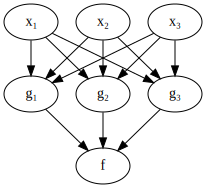

In [20]:
digraph = Digraph()

nodes = ["x₁", "x₂", "x₃", "g₁", "g₂", "g₃", "f"]
edges = [("x₁", "g₁"), ("x₁", "g₂"), ("x₁", "g₃"),
         ("x₂", "g₁"), ("x₂", "g₂"), ("x₂", "g₃"),
         ("x₃", "g₁"), ("x₃", "g₂"), ("x₃", "g₃"),
         ("g₁", "f"), ("g₂", "f"), ("g₃", "f")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

The number of paths from initial to terminal nodes increases dramatically with adding new nodes. Compared to $ f\big( g_1(x_1, x_2), g_2(x_1, x_2) \big) $, where we had only $ 2 \cdot 2 = 4 $ paths, this time, we have $ 3 \cdot 3 = 9 $.

This gets exponentially worse if we add another layer. Consider the following computational graph. (I don't even want to show you the expression it came from, let alone type it.)

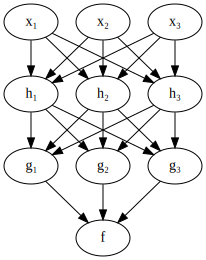

In [21]:
digraph = Digraph()

nodes = ["x₁", "x₂", "x₃", 
         "h₁", "h₂", "h₃",
         "g₁", "g₂", "g₃",
         "f"]
edges = [("x₁", "h₁"), ("x₁", "h₂"), ("x₁", "h₃"),
         ("x₂", "h₁"), ("x₂", "h₂"), ("x₂", "h₃"),
         ("x₃", "h₁"), ("x₃", "h₂"), ("x₃", "h₃"),
         ("h₁", "g₁"), ("h₁", "g₂"), ("h₁", "g₃"),
         ("h₂", "g₁"), ("h₂", "g₂"), ("h₂", "g₃"),
         ("h₃", "g₁"), ("h₃", "g₂"), ("h₃", "g₃"),
         ("g₁", "f"), ("g₂", "f"), ("g₃", "f")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

The number of paths to sum over has gone from $ 3^2 $ to $ 3^3 = 27 $. This is the dreaded exponential increase.

What can we do? Enter the backward-mode differentiation.

(section:computational-graphs/backwards-pass/backpropagation)=
## Backward-mode differentiation

Let's go back to the example $ f\big( g_1(x_1, x_2), g_2(x_1, x_2) \big) $. Here's its graph.

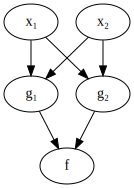

In [22]:
digraph = Digraph()

nodes = ["x₁", "x₂", "g₁", "g₂", "f"]
edges = [("x₁", "g₁"), ("x₁", "g₂"),
         ("x₂", "g₁"), ("x₂", "g₂"),
         ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

Previously, we have obtained $ \frac{df}{dx_1} $ and $ \frac{df}{dx_2} $ by computing two graphs:

* one with the nodes representing the partial derivatives with respect to $ x_1 $,
* and another with nodes representing the partial derivatives with respect to $ x_2 $.

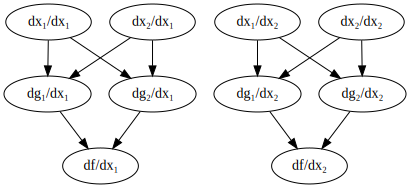

In [23]:
digraph = Digraph()

nodes = ["x₁", "x₂", "g₁", "g₂", "f"]
edges = [("x₁", "g₁"), ("x₁", "g₂"),
         ("x₂", "g₁"), ("x₂", "g₂"),
         ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(v, label=f"d{v}/dx₁")

for u, v in edges:
    digraph.edge(u, v)

offset = " "
for v in nodes:
    digraph.node(v + offset, label=f"d{v}/dx₂")

edges_offset = [(u + offset, v + offset) for u, v in edges]
for u, v in edges_offset:
    digraph.edge(u, v)

digraph

Let's turn it upside down! Instead of populating the graph with $ \frac{dv}{dx_i} $ for the node $ v $, we'll compute the derivatives $ \frac{df}{dv} $:

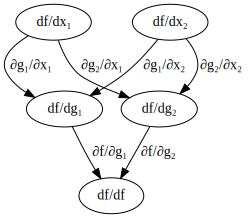

In [24]:
digraph = Digraph()


nodes = [("x₁", "df/dx₁"), ("x₂", "df/dx₂"), ("g₁", "df/dg₁"), ("g₂", "df/dg₂"), ("f", "df/df")]
edges = [("x₁", "g₁", "∂g₁/∂x₁"), ("x₁", "g₂", "∂g₂/∂x₁"),
         ("x₂", "g₁", "∂g₁/∂x₂"), ("x₂", "g₂", "∂g₂/∂x₂"),
         ("g₁", "f", "∂f/∂g₁"), ("g₂", "f", "∂f/∂g₂")]

for v, label in nodes:
    digraph.node(v, label=label)

for u, v, label in edges:
    digraph.edge(u, v, label=label)

digraph

Notice that this time, only the final node $ \frac{df}{df} = 1 $ is known to us; our goal is to compute the value of the initial nodes $ \frac{df}{dx_1} $ and $ \frac{df}{dx_2} $. Thus, we'll propagate the values backward along the edges, hence the name *backward-mode differentiation*. 

In other words, the order in which we calculate the global derivatives are

1. $ \frac{df}{df} $,
2. $ \frac{df}{dg_1} $ and $ \frac{df}{dg_2} $,
3. and finally, $ \frac{df}{dx_1} $ and $ \frac{df}{dx_2} $.

True to its name and forward-mode counterparts, the derivatives represented by the nodes are called the *backward derivatives*.

As before, let's carry out a concrete example by hand: $ (2 x_1 + 3 x_2) - 4 x_1 x_2 $. Factoring out, this is the composition of the functions

* $ g_1(x_1, x_2) = 2 x_1 + 3 x_2 $,
* $ g_2(x_1, x_2) = x_1 x_2 $,
* and $ f(g_1, g_2) = g_1 - 4 g_2 $.

(There are alternative decompositions, but we'll stick with this one.) The derivatives are

$$
\frac{\partial g_1}{\partial x_1} = 2, \quad \frac{\partial g_1}{\partial x_2} = 3, \quad \frac{\partial g_2}{\partial x_1} = x_2, \quad \frac{\partial g_2}{\partial x_2} = x_1,
$$

and

$$
\frac{\partial f}{\partial g_1} = 1, \quad \frac{\partial f}{\partial g_2} = - 4.
$$

This is our starting point:

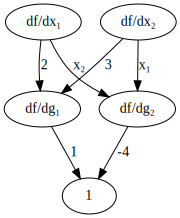

In [25]:
digraph = Digraph()


nodes = [("x₁", "df/dx₁"), ("x₂", "df/dx₂"), ("g₁", "df/dg₁"), ("g₂", "df/dg₂"), ("f", "1")]
edges = [("x₁", "g₁", "2"), ("x₁", "g₂", "x₂"),
         ("x₂", "g₁", "3"), ("x₂", "g₂", "x₁"),
         ("g₁", "f", "1"), ("g₂", "f", "-4")]

for v, label in nodes:
    digraph.node(v, label=label)

for u, v, label in edges:
    digraph.edge(u, v, label=label)

digraph

In the first step, we calculate the derivatives on the previous level via propagating $ \frac{df}{df} = 1 $ backwards via the edges to obtain

$$
\frac{df}{dg_1} = 1 \cdot 1, \quad \frac{df}{dg_2} = 1 \cdot (-4).
$$

In graph terms, we have the following:

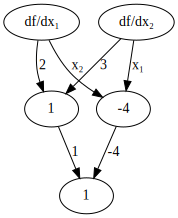

In [26]:
digraph = Digraph()


nodes = [("x₁", "df/dx₁"), ("x₂", "df/dx₂"), ("g₁", "1"), ("g₂", "-4"), ("f", "1")]
edges = [("x₁", "g₁", "2"), ("x₁", "g₂", "x₂"),
         ("x₂", "g₁", "3"), ("x₂", "g₂", "x₁"),
         ("g₁", "f", "1"), ("g₂", "f", "-4")]

for v, label in nodes:
    digraph.node(v, label=label)

for u, v, label in edges:
    digraph.edge(u, v, label=label)

digraph

One final step, and we have

$$
\frac{df}{dx_1} = 1 \cdot 2 - 4 \cdot x_2, \quad \frac{df}{dx_2} = 1 \cdot 3 - 4\cdot  x_1,
$$

or in graph terms, the following:

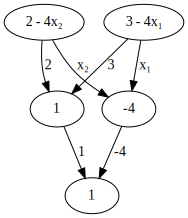

In [27]:
digraph = Digraph()


nodes = [("x₁", "2 - 4x₂"), ("x₂", "3 - 4x₁"), ("g₁", "1"), ("g₂", "-4"), ("f", "1")]
edges = [("x₁", "g₁", "2"), ("x₁", "g₂", "x₂"),
         ("x₂", "g₁", "3"), ("x₂", "g₂", "x₁"),
         ("g₁", "f", "1"), ("g₂", "f", "-4")]

for v, label in nodes:
    digraph.node(v, label=label)

for u, v, label in edges:
    digraph.edge(u, v, label=label)

digraph

(The expression $ (2 x_1 + 3 x_2) - 4 x_1 x_2 $ is easy to differentiate by hand, so feel free to verify our results.)

To sum up with a pseudoalgorithm, we did something like this.

```
for v in nodes:
    # the backward step for v
    for u, u_local_grad in v.prevs:
        u.backwards_grad += v.backwards_grad * u_local_grad
```

What we've just seen is called *backpropagation*, the primary way to compute derivatives of computational graphs. Why is it better than its forward-mode counterpart? Because it requires only one pass, compared to the as-many-passes-as-variables approach of forward-mode differentiation. This is a huge deal in machine learning, where we can have billions of parameters.

So, how do we implement backpropagation in practice? See you in the next chapter!